In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

In [3]:
data = pd.read_csv('/kaggle/input/ukraine-vs-russia-tweets-dataset/filename.csv')
print(data.head())

                    id      conversation_id               created_at  \
0  1630366235354451969  1630152070530576385  2023-02-28 00:36:15 UTC   
1  1630366226424778753  1630366226424778753  2023-02-28 00:36:13 UTC   
2  1630366225930027011  1630366225930027011  2023-02-28 00:36:13 UTC   
3  1630366223056662530  1630351686974992385  2023-02-28 00:36:12 UTC   
4  1630366221483884545  1629903982255644672  2023-02-28 00:36:12 UTC   

         date      time  timezone              user_id     username  \
0  2023-02-28  00:36:15         0  1493761817406894086  tomasliptai   
1  2023-02-28  00:36:13         0  1526694166662721536  paperfloure   
2  2023-02-28  00:36:13         0  1053018392939167746    katetbar1   
3  2023-02-28  00:36:12         0            602371247    jlhrdhmom   
4  2023-02-28  00:36:12         0  1053594763214184448    phemikali   

                  name place  ... geo source user_rt_id user_rt retweet_id  \
0         Tomas Liptai   NaN  ... NaN    NaN        NaN     Na

# Let’s have a quick look at all the column names of the dataset

In [5]:
print(data.columns)

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')


We only need three columns for this task (username, tweet, and language); I will only select these columns and move forward:

In [6]:
data = data[["username", "tweet", "language"]]

Let’s have a look at whether any of these columns contains any null values or not:

In [7]:
data.isnull().sum()

username    0
tweet       0
language    0
dtype: int64

So none of the columns has null values, let’s have a quick look at how many tweets are posted in which language:

In [8]:
data["language"].value_counts()

en     8858
pt      440
it      194
qme     105
und      60
in       47
ru       44
ja       42
es       36
ca       20
qht      20
th       19
fr       18
de       14
ko        9
vi        8
nl        8
ro        7
fi        7
ar        6
zxx       6
uk        6
cs        6
zh        5
pl        5
qam       4
tl        4
da        3
eu        2
no        2
hi        2
tr        2
hu        1
cy        1
lv        1
el        1
bn        1
Name: language, dtype: int64

So most of the tweets are in English. Let’s prepare this data for the task of sentiment analysis. Here I will remove all the links, punctuation, symbols and other language errors from the tweets:

In [ ]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["tweet"] = data["tweet"].apply(clean)

Now let’s have a look at the wordcloud of the tweets, which will show the most frequently used words in the tweets by people sharing their feelings and updates about the Ukraine and Russia war:

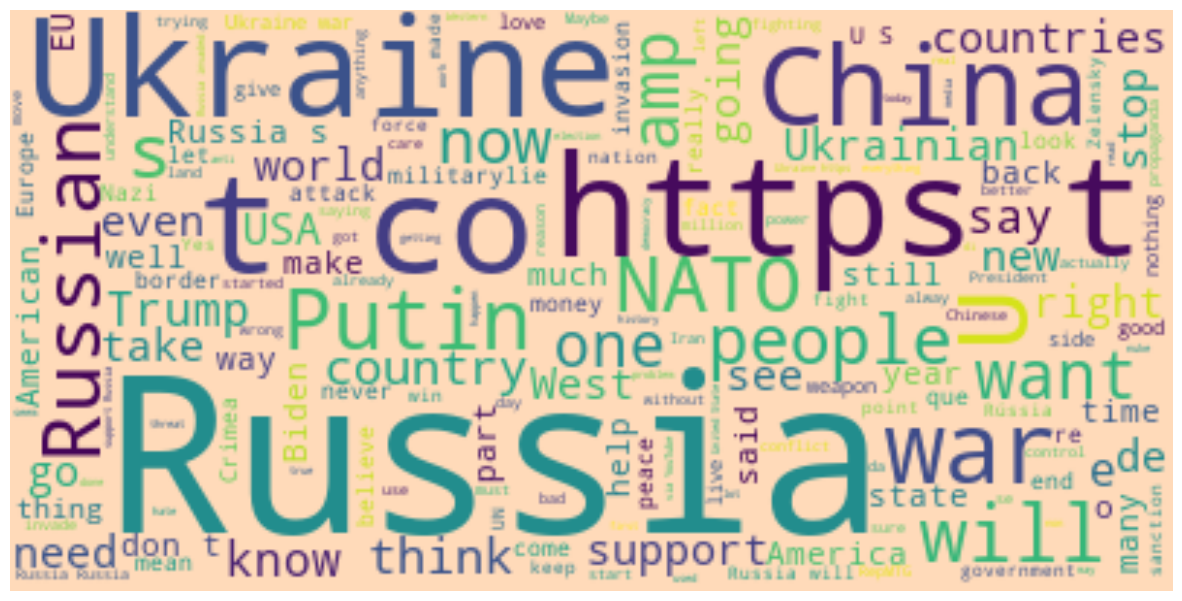

In [48]:
text = " ".join(i for i in data.tweet)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="peachpuff").generate(text)
plt.figure( figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now I will add three more columns in this dataset as Positive, Negative, and Neutral by calculating the sentiment scores of the tweets:

In [21]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["tweet"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["tweet"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["tweet"]]
data = data[["tweet", "Positive", "Negative", "Neutral"]]
print(data.head())

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
                                               tweet  Positive  Negative  \
0  @nazijaeger__ @derwener @Anonymous9775 Russia ...     0.189     0.000   
1  The Russia HAARP which could destroy USA in on...     0.000     0.308   
2  Putin gives Steven Seagal Russia&amp;#8217;s O...     0.266     0.000   
3  @MainelifeR @BaddCompani It’s ALWAYS PROJECTIO...     0.000     0.000   
4  @Pottingpinks @mfa_russia @mod_russia @mil_his...     0.043     0.074   

   Neutral  
0    0.811  
1    0.692  
2    0.734  
3    1.000  
4    0.883  


Now let’s have a look at the most frequent words used by people with positive sentiments:

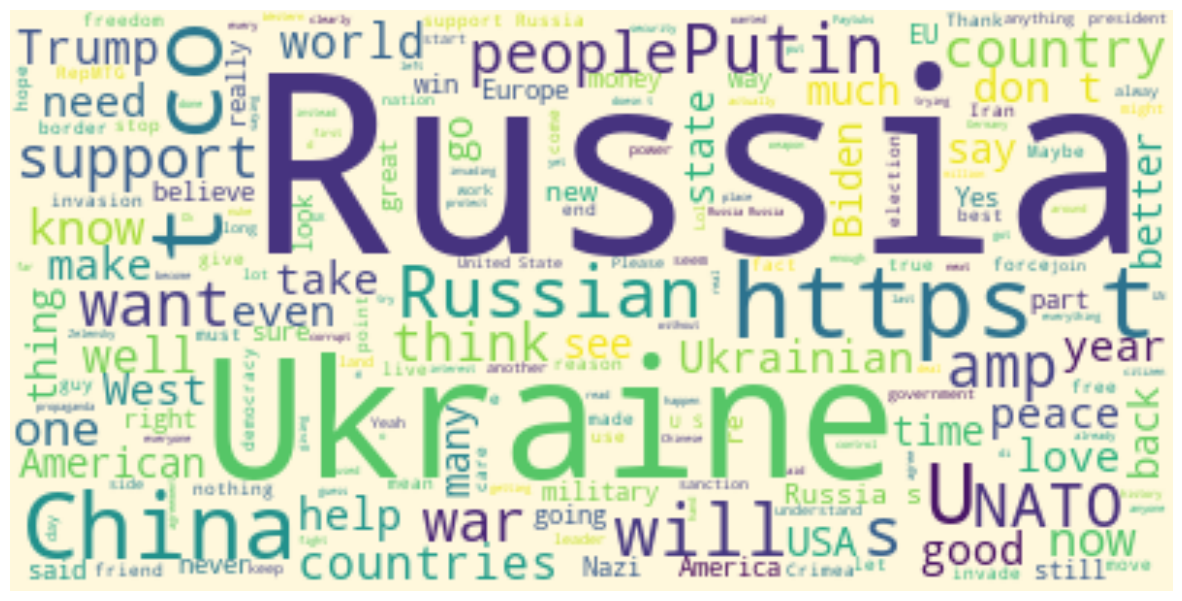

In [65]:
positive =' '.join([i for i in data['tweet'][data['Positive'] > data["Negative"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="cornsilk").generate(positive)
plt.figure( figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now let’s have a look at the most frequent words used by people with negative sentiments:

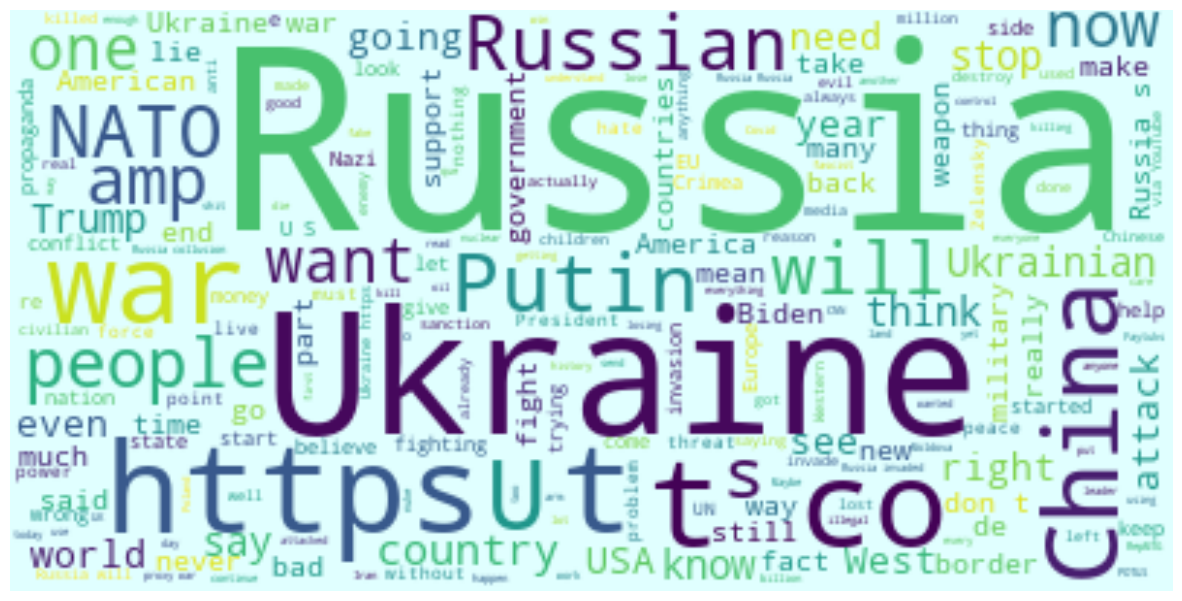

In [57]:
negative =' '.join([i for i in data['tweet'][data['Negative'] > data["Positive"]]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="lightcyan").generate(negative)
plt.figure( figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

So this is how you can analyze the sentiments of people over the Ukraine and Russia war. I hope this war gets over soon and things get back to normal.